# Evaluation part I

Evaluate LLM responses when there is a single "right answer".

## Setup
#### Load the API key and relevant Python libaries.
In this course, we've provided some code that loads the OpenAI API key for you.

In [ ]:
import os
import openai
import sys
sys.path.append('../..')
import utils
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [ ]:
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=500):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, 
        max_tokens=max_tokens, 
    )
    return response.choices[0].message["content"]

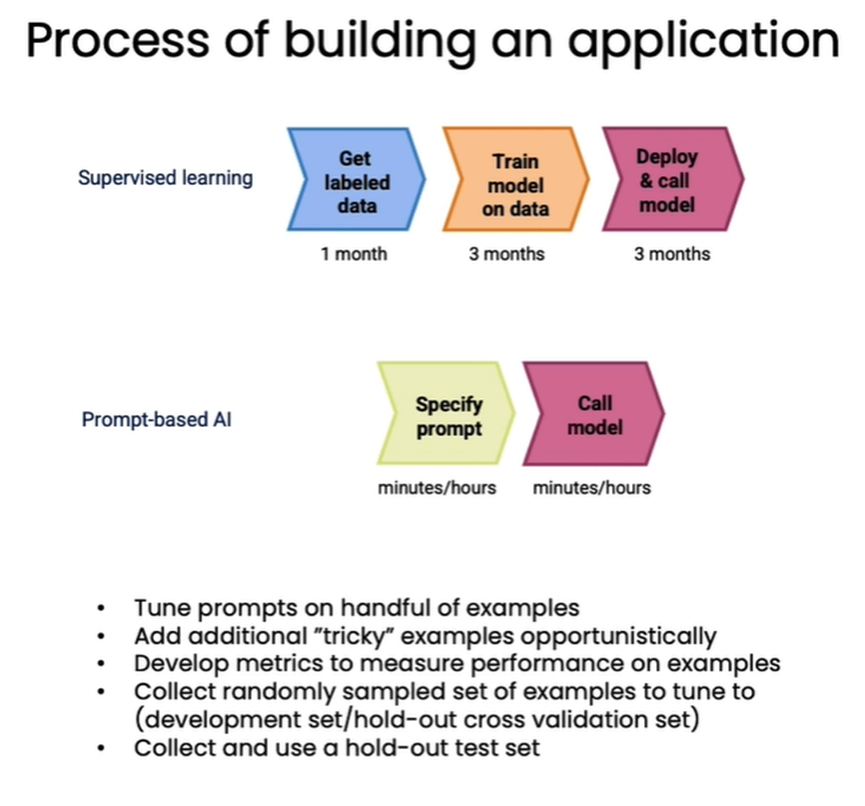

#### Get the relevant products and categories
Here is the list of products and categories that are in the product catalog.

In [ ]:
products_and_category = utils.get_products_and_category()
products_and_category

### Find relevant product and category names (version 1)
This could be the version that is running in production.

In [ ]:
def find_category_and_product_v1(user_input,products_and_category):

    delimiter = "####"
    system_message = f"""
    You will be provided with customer service queries. \
    The customer service query will be delimited with {delimiter} characters.
    Output a python list of json objects, where each object has the following format:
        'category': <one of Computers and Laptops, Smartphones and Accessories, Televisions and Home Theater Systems, \
    Gaming Consoles and Accessories, Audio Equipment, Cameras and Camcorders>,
    AND
        'products': <a list of products that must be found in the allowed products below>


    Where the categories and products must be found in the customer service query.
    If a product is mentioned, it must be associated with the correct category in the allowed products list below.
    If no products or categories are found, output an empty list.
    

    List out all products that are relevant to the customer service query based on how closely it relates
    to the product name and product category.
    Do not assume, from the name of the product, any features or attributes such as relative quality or price.

    The allowed products are provided in JSON format.
    The keys of each item represent the category.
    The values of each item is a list of products that are within that category.
    Allowed products: {products_and_category}
    

    """
    
    few_shot_user_1 = """I want the most expensive computer."""
    few_shot_assistant_1 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    messages =  [  
    {'role':'system', 'content': system_message},    
    {'role':'user', 'content': f"{delimiter}{few_shot_user_1}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_1 },
    {'role':'user', 'content': f"{delimiter}{user_input}{delimiter}"},  
    ] 
    return get_completion_from_messages(messages)


### Evaluate on some queries

In [ ]:
customer_msg_0 = f"""Which TV can I buy if I'm on a budget?"""

products_by_category_0 = find_category_and_product_v1(customer_msg_0,
                                                      products_and_category)
print(products_by_category_0)

In [ ]:
customer_msg_1 = f"""I need a charger for my smartphone"""

products_by_category_1 = find_category_and_product_v1(customer_msg_1,
                                                      products_and_category)
print(products_by_category_1)

In [ ]:
customer_msg_2 = f"""
What computers do you have?"""

products_by_category_2 = find_category_and_product_v1(customer_msg_2,
                                                      products_and_category)
products_by_category_2

In [ ]:
customer_msg_3 = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs do you have?"""

products_by_category_3 = find_category_and_product_v1(customer_msg_3,
                                                      products_and_category)
print(products_by_category_3)

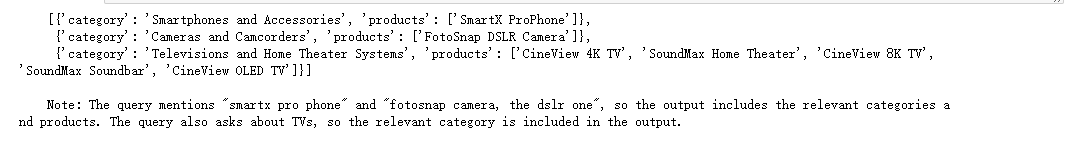

### Harder test cases
Identify queries found in production, where the model is not working as expected.

In [ ]:
customer_msg_4 = f"""
tell me about the CineView TV, the 8K one, Gamesphere console, the X one.
I'm on a budget, what computers do you have?"""

products_by_category_4 = find_category_and_product_v1(customer_msg_4,
                                                      products_and_category)
print(products_by_category_4)

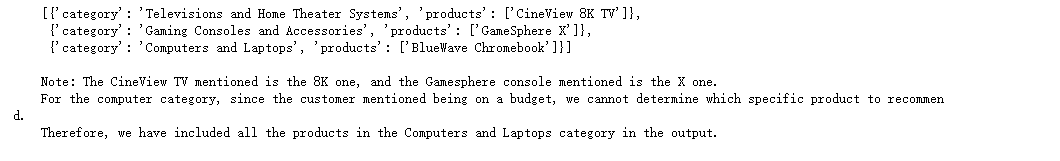

### Modify the prompt to work on the hard test cases

In [ ]:
def find_category_and_product_v2(user_input,products_and_category):
    """
    Added: Do not output any additional text that is not in JSON format.
    Added a second example (for few-shot prompting) where user asks for 
    the cheapest computer. In both few-shot examples, the shown response 
    is the full list of products in JSON only.
    """
    delimiter = "####"
    system_message = f"""
    You will be provided with customer service queries. \
    The customer service query will be delimited with {delimiter} characters.
    Output a python list of json objects, where each object has the following format:
        'category': <one of Computers and Laptops, Smartphones and Accessories, Televisions and Home Theater Systems, \
    Gaming Consoles and Accessories, Audio Equipment, Cameras and Camcorders>,
    AND
        'products': <a list of products that must be found in the allowed products below>
    Do not output any additional text that is not in JSON format.
    Do not write any explanatory text after outputting the requested JSON.


    Where the categories and products must be found in the customer service query.
    If a product is mentioned, it must be associated with the correct category in the allowed products list below.
    If no products or categories are found, output an empty list.
    

    List out all products that are relevant to the customer service query based on how closely it relates
    to the product name and product category.
    Do not assume, from the name of the product, any features or attributes such as relative quality or price.

    The allowed products are provided in JSON format.
    The keys of each item represent the category.
    The values of each item is a list of products that are within that category.
    Allowed products: {products_and_category}
    

    """
    
    few_shot_user_1 = """I want the most expensive computer. What do you recommend?"""
    few_shot_assistant_1 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    few_shot_user_2 = """I want the most cheapest computer. What do you recommend?"""
    few_shot_assistant_2 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    messages =  [  
    {'role':'system', 'content': system_message},    
    {'role':'user', 'content': f"{delimiter}{few_shot_user_1}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_1 },
    {'role':'user', 'content': f"{delimiter}{few_shot_user_2}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_2 },
    {'role':'user', 'content': f"{delimiter}{user_input}{delimiter}"},  
    ] 
    return get_completion_from_messages(messages)


### Evaluate the modified prompt on the hard tests cases

In [ ]:
customer_msg_3 = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs do you have?"""

products_by_category_3 = find_category_and_product_v2(customer_msg_3,
                                                      products_and_category)
print(products_by_category_3)

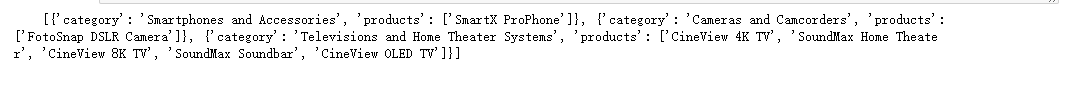

### Regression testing: verify that the model still works on previous test cases
Check that modifying the model to fix the hard test cases does not negatively affect its performance on previous test cases.

In [ ]:
customer_msg_0 = f"""Which TV can I buy if I'm on a budget?"""

products_by_category_0 = find_category_and_product_v2(customer_msg_0,
                                                      products_and_category)
print(products_by_category_0)

### Gather development set for automated testing

In [ ]:
msg_ideal_pairs_set = [
    
    # eg 0
    {'customer_msg':"""Which TV can I buy if I'm on a budget?""",
     'ideal_answer':{
        'Televisions and Home Theater Systems':set(
            ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']
        )}
    },

    # eg 1
    {'customer_msg':"""I need a charger for my smartphone""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['MobiTech PowerCase', 'MobiTech Wireless Charger', 'SmartX EarBuds']
        )}
    },
    # eg 2
    {'customer_msg':f"""What computers do you have?""",
     'ideal_answer':{
           'Computers and Laptops':set(
               ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook'
               ])
                }
    },

    # eg 3
    {'customer_msg':f"""tell me about the smartx pro phone and \
    the fotosnap camera, the dslr one.\
    Also, what TVs do you have?""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['SmartX ProPhone']),
        'Cameras and Camcorders':set(
            ['FotoSnap DSLR Camera']),
        'Televisions and Home Theater Systems':set(
            ['CineView 4K TV', 'SoundMax Home Theater','CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV'])
        }
    }, 
    
    # eg 4
    {'customer_msg':"""tell me about the CineView TV, the 8K one, Gamesphere console, the X one.
I'm on a budget, what computers do you have?""",
     'ideal_answer':{
        'Televisions and Home Theater Systems':set(
            ['CineView 8K TV']),
        'Gaming Consoles and Accessories':set(
            ['GameSphere X']),
        'Computers and Laptops':set(
            ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook'])
        }
    },
    
    # eg 5
    {'customer_msg':f"""What smartphones do you have?""",
     'ideal_answer':{
           'Smartphones and Accessories':set(
               ['SmartX ProPhone', 'MobiTech PowerCase', 'SmartX MiniPhone', 'MobiTech Wireless Charger', 'SmartX EarBuds'
               ])
                    }
    },
    # eg 6
    {'customer_msg':f"""I'm on a budget.  Can you recommend some smartphones to me?""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['SmartX EarBuds', 'SmartX MiniPhone', 'MobiTech PowerCase', 'SmartX ProPhone', 'MobiTech Wireless Charger']
        )}
    },

    # eg 7 # this will output a subset of the ideal answer
    {'customer_msg':f"""What Gaming consoles would be good for my friend who is into racing games?""",
     'ideal_answer':{
        'Gaming Consoles and Accessories':set([
            'GameSphere X',
            'ProGamer Controller',
            'GameSphere Y',
            'ProGamer Racing Wheel',
            'GameSphere VR Headset'
     ])}
    },
    # eg 8
    {'customer_msg':f"""What could be a good present for my videographer friend?""",
     'ideal_answer': {
        'Cameras and Camcorders':set([
        'FotoSnap DSLR Camera', 'ActionCam 4K', 'FotoSnap Mirrorless Camera', 'ZoomMaster Camcorder', 'FotoSnap Instant Camera'
        ])}
    },
    
    # eg 9
    {'customer_msg':f"""I would like a hot tub time machine.""",
     'ideal_answer': []
    }
    
]


### Evaluate test cases by comparing to the ideal answers

In [ ]:
import json
def eval_response_with_ideal(response,
                              ideal,
                              debug=False):
    
    if debug:
        print("response")
        print(response)
    
    # json.loads() expects double quotes, not single quotes
    json_like_str = response.replace("'",'"')
    
    # parse into a list of dictionaries
    l_of_d = json.loads(json_like_str)
    
    # special case when response is empty list
    if l_of_d == [] and ideal == []:
        return 1
    
    # otherwise, response is empty 
    # or ideal should be empty, there's a mismatch
    elif l_of_d == [] or ideal == []:
        return 0
    
    correct = 0    
    
    if debug:
        print("l_of_d is")
        print(l_of_d)
    for d in l_of_d:

        cat = d.get('category')
        prod_l = d.get('products')
        if cat and prod_l:
            # convert list to set for comparison
            prod_set = set(prod_l)
            # get ideal set of products
            ideal_cat = ideal.get(cat)
            if ideal_cat:
                prod_set_ideal = set(ideal.get(cat))
            else:
                if debug:
                    print(f"did not find category {cat} in ideal")
                    print(f"ideal: {ideal}")
                continue
                
            if debug:
                print("prod_set\n",prod_set)
                print()
                print("prod_set_ideal\n",prod_set_ideal)

            if prod_set == prod_set_ideal:
                if debug:
                    print("correct")
                correct +=1
            else:
                print("incorrect")
                print(f"prod_set: {prod_set}")
                print(f"prod_set_ideal: {prod_set_ideal}")
                if prod_set <= prod_set_ideal:
                    print("response is a subset of the ideal answer")
                elif prod_set >= prod_set_ideal:
                    print("response is a superset of the ideal answer")

    # count correct over total number of items in list
    pc_correct = correct / len(l_of_d)
        
    return pc_correct

In [ ]:
print(f'Customer message: {msg_ideal_pairs_set[0]["customer_msg"]}')
print(f'Ideal answer: {msg_ideal_pairs_set[0]["ideal_answer"]}')

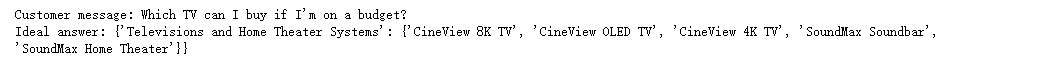

In [ ]:
response = find_category_and_product_v2(msg_ideal_pairs_set[0]["customer_msg"],
                                         products_and_category)
print(f'Resonse: {response}')

eval_response_with_ideal(response,
                              msg_ideal_pairs_set[0]["ideal_answer"])

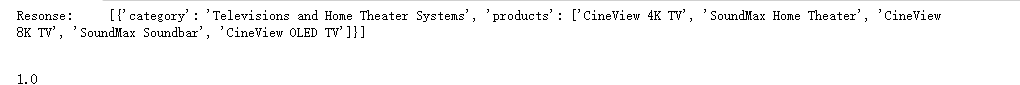

In [ ]:
print(f'Customer message: {msg_ideal_pairs_set[7]["customer_msg"]}')
print(f'Ideal answer: {msg_ideal_pairs_set[7]["ideal_answer"]}')


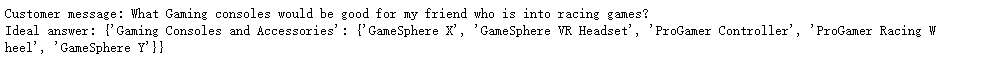

In [ ]:
response = find_category_and_product_v2(msg_ideal_pairs_set[7]["customer_msg"],
                                         products_and_category)
print(f'Resonse: {response}')

eval_response_with_ideal(response,
                              msg_ideal_pairs_set[7]["ideal_answer"])

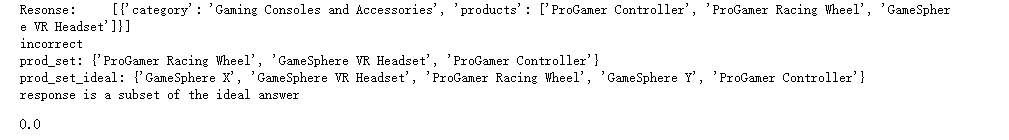

### Run evaluation on all test cases and calculate the fraction of cases that are correct

In [ ]:
# Note, this will not work if any of the api calls time out
score_accum = 0
for i, pair in enumerate(msg_ideal_pairs_set):
    print(f"example {i}")
    
    customer_msg = pair['customer_msg']
    ideal = pair['ideal_answer']
    
    # print("Customer message",customer_msg)
    # print("ideal:",ideal)
    response = find_category_and_product_v2(customer_msg,
                                                      products_and_category)

    
    # print("products_by_category",products_by_category)
    score = eval_response_with_ideal(response,ideal,debug=False)
    print(f"{i}: {score}")
    score_accum += score
    

n_examples = len(msg_ideal_pairs_set)
fraction_correct = score_accum / n_examples
print(f"Fraction correct out of {n_examples}: {fraction_correct}")

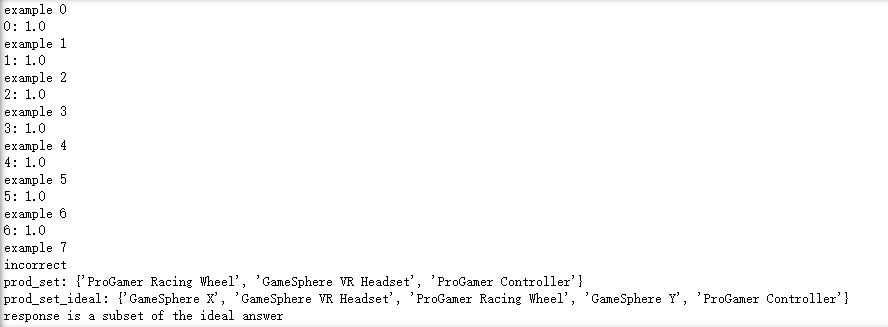